<a href="https://colab.research.google.com/github/RajBharti25/ILD/blob/master/SUMNet_lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import time

# Imports from torch for neural networks
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
TrainImages=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TrainImages.pt')
TrainLabels=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TrainLabels.pt')
TestImages=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TestImages.pt')
TestLabels=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TestLabels.pt')
#Printing out the data size for verification
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([1398, 1, 512, 512])
torch.Size([1398, 512, 512])
torch.Size([9, 1, 512, 512])
torch.Size([9, 512, 512])


In [ ]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 4
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False)

# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        
        self.encoder   = models.vgg11(pretrained = True).features
        self.preconv   = nn.Conv2d(1, 3, 1)
        self.conv1     = self.encoder[0]
        self.pool1     = nn.MaxPool2d(2, 2, return_indices = True)
        self.conv2     = self.encoder[3]
        self.pool2     = nn.MaxPool2d(2, 2, return_indices = True)
        self.conv3a    = self.encoder[6]
        self.conv3b    = self.encoder[8]
        self.pool3     = nn.MaxPool2d(2, 2, return_indices = True)
        self.conv4a    = self.encoder[11]
        self.conv4b    = self.encoder[13]
        self.pool4     = nn.MaxPool2d(2, 2, return_indices = True)
        self.conv5a    = self.encoder[16]
        self.conv5b    = self.encoder[18]
        self.pool5     = nn.MaxPool2d(2, 2, return_indices = True)
        
        self.unpool5   = nn.MaxUnpool2d(2, 2)
        self.donv5b    = nn.Conv2d(1024, 512, 3, padding = 1)
        self.donv5a    = nn.Conv2d(512, 512, 3, padding = 1)
        self.unpool4   = nn.MaxUnpool2d(2, 2)
        self.donv4b    = nn.Conv2d(1024, 512, 3, padding = 1)
        self.donv4a    = nn.Conv2d(512, 256, 3, padding = 1)
        self.unpool3   = nn.MaxUnpool2d(2, 2)
        self.donv3b    = nn.Conv2d(512, 256, 3, padding = 1)
        self.donv3a    = nn.Conv2d(256,128, 3, padding = 1)
        self.unpool2   = nn.MaxUnpool2d(2, 2)
        self.donv2     = nn.Conv2d(256, 64, 3, padding = 1)
        self.unpool1   = nn.MaxUnpool2d(2, 2)
        self.donv1     = nn.Conv2d(128, 32, 3, padding = 1)
        self.output    = nn.Conv2d(32, 4, 1)
        
    def forward(self, x):
        preconv        = F.relu(self.preconv(x), inplace = True)
        conv1          = F.relu(self.conv1(preconv), inplace = True)
        pool1, idxs1   = self.pool1(conv1)
        conv2          = F.relu(self.conv2(pool1), inplace = True)
        pool2, idxs2   = self.pool2(conv2)
        conv3a         = F.relu(self.conv3a(pool2), inplace = True)
        conv3b         = F.relu(self.conv3b(conv3a), inplace = True)
        pool3, idxs3   = self.pool3(conv3b)
        conv4a         = F.relu(self.conv4a(pool3), inplace = True)
        conv4b         = F.relu(self.conv4b(conv4a), inplace = True)
        pool4, idxs4   = self.pool4(conv4b)
        conv5a         = F.relu(self.conv5a(pool4), inplace = True)
        conv5b         = F.relu(self.conv5b(conv5a), inplace = True)
        pool5, idxs5   = self.pool5(conv5b)
        
        unpool5        = torch.cat([self.unpool5(pool5, idxs5), conv5b], 1)
        donv5b         = F.relu(self.donv5b(unpool5), inplace = True)
        donv5a         = F.relu(self.donv5a(donv5b), inplace = True)
        unpool4        = torch.cat([self.unpool4(donv5a, idxs4), conv4b], 1)
        donv4b         = F.relu(self.donv4b(unpool4), inplace = True)
        donv4a         = F.relu(self.donv4a(donv4b), inplace = True)
        unpool3        = torch.cat([self.unpool3(donv4a, idxs3), conv3b], 1)
        donv3b         = F.relu(self.donv3b(unpool3), inplace = True)
        donv3a         = F.relu(self.donv3a(donv3b))
        unpool2        = torch.cat([self.unpool2(donv3a, idxs2), conv2], 1)
        donv2          = F.relu(self.donv2(unpool2), inplace = True)
        unpool1        = torch.cat([self.unpool1(donv2, idxs1), conv1], 1)
        donv1          = F.relu(self.donv1(unpool1), inplace = True)
        output         = self.output(donv1)
        return output

In [ ]:
net = SegNet()
if use_gpu:
    net = net.cuda()

criterion = nn.CrossEntropyLoss() # 2D Negative Log-Likelihood
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At dataloder: 0;  instant  Loss: 1.454218
At dataloder: 100;  instant  Loss: 0.113996
At dataloder: 200;  instant  Loss: 0.041826
At dataloder: 300;  instant  Loss: 0.020911
At Iteration: 1 /2  ;  Training Loss: 0.171250; Time consumed: 9m 7s 
At dataloder: 0;  instant  Loss: 0.043721
At dataloder: 100;  instant  Loss: 0.029118
At dataloder: 200;  instant  Loss: 0.032925
At dataloder: 300;  instant  Loss: 0.073744
At Iteration: 2 /2  ;  Training Loss: 0.043113; Time consumed: 9m 5s 
Training completed in 18m 12s


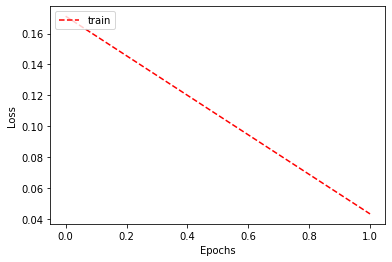

In [ ]:
iterations = 2
trainLoss = []
testLoss = []
start = time.time()
avgTrainLoss=500
lowest_loss=100
PATH='/content/gdrive/My Drive/Colab Notebook/ILD/Unet_roi.pt'
for epoch in range(iterations):
    l=0
    if(avgTrainLoss<=lowest_loss and epoch>1):
      lowest_loss=avgTrainLoss
      torch.save(net.state_dict(), PATH)
    epochStart = time.time()
    runningLoss = 0
    net.train(True) # For training
    
    for data in trainLoader:
        inputs,labels = data
        # inputs=F.interpolate(inputs, (572,572))
        # p2d = (30, 30, 30, 30) # pad last dim by (30, 30) and 2nd to last by (30, 30)
        # inputs = F.pad(inputs, p2d, "constant", 0)
        # labels=labels[:,:484,:484]
        # labels=labels.data.cpu().numpy()
        # idx=np.where(labels!=0)
        # labels[idx]=1
        # labels=torch.from_numpy(labels)
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())
        # Feed-forward input data through the network
        outputs = net(inputs)
        outputs = outputs.permute(0, 2, 3, 1)
        # Compute loss/error
        width_out=outputs.shape[1]
        height_out=outputs.shape[2]
        m = outputs.shape[0]

        outputs = outputs.resize(m*width_out*height_out, 4)
        labels = labels.resize(m*width_out*height_out)
        loss = criterion(outputs, labels.long())
        # loss = criterion(F.softmax(outputs, dim=1), labels)    
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data.item()
        if l%100==0:
          print('At dataloder: {:.0f};  instant  Loss: {:.6f}'\
                .format(l,loss.data.item()))
        l=l+1
        # print(runningLoss, loss.data.item())
    avgTrainLoss = runningLoss/500.0    
    trainLoss.append(avgTrainLoss)
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')     
    # plt.plot(range(epoch+1),testLoss,'g--',label='test')      
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
      
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    # print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
    #       .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [ ]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
  # """Altered Sorensen–Dice coefficient with epsilon for smoothing."""
  y_true_flatten = np.asarray(y_true).astype(np.bool)
  y_pred_flatten = np.asarray(y_pred).astype(np.bool)

  if not np.sum(y_true_flatten) + np.sum(y_pred_flatten):
      return 1.0

  return (2. * np.sum(y_true_flatten * y_pred_flatten)) /\
        (np.sum(y_true_flatten) + np.sum(y_pred_flatten) + epsilon)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Original Mask')

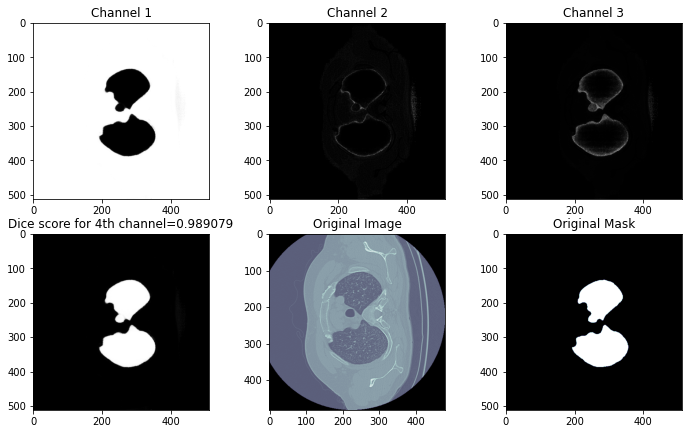

In [ ]:
a=[5,500,1300]
randIdx = 1300
testImg = TrainImages[randIdx]

testLab = TrainLabels[randIdx].numpy()

# Feed-forward
segImg = net(Variable(testImg).unsqueeze(0).cuda())
# Applying softmax to get class probabilities
segImg_np = F.softmax(segImg).data.cpu().squeeze(0).numpy()

# Displaying segmented output and ground truth
plt.figure(figsize=(12,11))

plt.subplot(331)
plt.imshow(segImg_np[0,:,:],cmap='gray')
plt.title('Channel 1')
plt.subplot(332)
plt.imshow(segImg_np[1,:,:],cmap='gray')
plt.title('Channel 2')
plt.subplot(333)
plt.imshow(segImg_np[2,:,:],cmap='gray')
plt.title('Channel 3')

testLab=testLab/np.amax(testLab)
a=np.where(segImg_np>=0.5)
b=np.where(segImg_np<0.5)
img=segImg_np.copy()
img[a]=1
img[b]=0

plt.subplot(334)
plt.imshow(segImg_np[3,:,:],cmap='gray')
dice=dice_coef(testLab,img[3])

plt.title('Dice score for 4th channel={:f}'.format(dice))
plt.subplot(335)
plt.imshow(testImg.squeeze(0)[30:542,30:542],cmap='bone')
plt.title('Original Image')
plt.subplot(336)
plt.imshow(testLab,cmap='bone')
plt.title('Original Mask')
